In [1]:
import os
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
                                  OneHotEncoder, LabelEncoder

def load_ptype_data(data_path, source, train_start='20130101', train_end='20150630',
                    val_start='20150701', val_end='20160630',
                    test_start='20160701', test_end='20180531'):
    """
    Load Precip Type data
    Args:
        data_path (str): Path to data
        source (str): Precip observation source. Supports 'ASOS' or 'mPING'.
        train_start (str): Train split start date (format yyyymmdd).
        train_end (str): Train split end date (format yyyymmdd).
        val_start (str): Valid split start date (format yyyymmdd).
        val_end (str): Valid split end date (format yyyymmdd).
        test_start (str): Test split start date (format yyyymmdd).
        test_end (str): Test split end date (format yyyymmdd).        
    Returns:
    Dictionary of Pandas dataframes of training / validation / test data
    """
    
    dates = sorted([x[-16:-8] for x in os.listdir(os.path.join(data_path))])
    
    data = {}
    data['train'] = dates[dates.index(train_start) : dates.index(train_end) + 1]
    data['val'] = dates[dates.index(val_start) : dates.index(val_end) + 1]
    data['test'] = dates[dates.index(test_start) : dates.index(test_end) + 1]
    
    for split in data.keys():
        dfs = []
        for date in tqdm(data[split], desc=f"{split}"):
            f = f"{source}_rap_{date}.parquet"
            dfs.append(pd.read_parquet(os.path.join(data_path, f)))
        data[split] = pd.concat(dfs, ignore_index=True)            

    return data

def preprocess_data(data, input_features, output_features, scaler_type="standard", encoder_type="onehot"):
    """
    Function to select features and scale data for ML
    Args:
        data (dictionary of dataframes for training and validation data):
        input_features (list): Input features
        output_feature (list): Output feature
        scaler_type: Type of scaling to perform (supports "standard" and "minmax")
        encoder_type: Type of encoder to perform (supports "label" and "onehot")
    Returns:
        Dictionary of scaled and one-hot encoded data, dictionary of scaler objects
    """
    scalar_obs = {"minmax": MinMaxScaler, "standard": StandardScaler}
    scalers, scaled_data = {}, {}

    scalers["input"] = scalar_obs[scaler_type]()
    scaled_data["train_x"] = pd.DataFrame(scalers["input"].fit_transform(data["train"][input_features]),
                                          columns=input_features)
    scaled_data["val_x"] = pd.DataFrame(scalers["input"].transform(data["val"][input_features]), columns=input_features)
    scaled_data["test_x"] = pd.DataFrame(scalers["input"].transform(data["test"][input_features]), columns=input_features)

    scalers["output_label"] = LabelEncoder()
    scaled_data["train_y"] = scalers["output_label"].fit_transform(data['train']['precip'])
    scaled_data["val_y"] = scalers["output_label"].transform(data['val']['precip'])
    scaled_data["test_y"] = scalers["output_label"].transform(data['test']['precip'])

    if encoder_type == "onehot":
        scalers["output_onehot"] = OneHotEncoder(sparse=False)
        scaled_data["train_y"] = scalers["output_onehot"].fit_transform(scaled_data["train_y"].reshape(len(scaled_data["train_y"]), 1))
        scaled_data["val_y"] = scalers["output_onehot"].transform(scaled_data["val_y"].reshape(len(scaled_data["val_y"]), 1))
        scaled_data["test_y"] = scalers["output_onehot"].transform(scaled_data["test_y"].reshape(len(scaled_data["test_y"]), 1))

    return scaled_data, scalers


def reshape_data_1dCNN(data, base_variables=['TEMP_C', 'T_DEWPOINT_C', 'UGRD_m/s', 'VGRD_m/s'], n_levels=67):
    
    arr = np.zeros(shape=(data.shape[0], n_levels, len(base_variables))).astype('float32')
    
    for i, var in enumerate(base_variables):
        
        profile_vars = [x for x in list(data.columns) if var in x]
        arr[:, :, i] = data[profile_vars].values.astype('float32')
    
    return arr

In [2]:
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPool1D, AveragePooling1D, AvgPool1D, Activation, Input, Flatten, AveragePooling2D, MaxPool2D, LeakyReLU
from tensorflow.keras.layers import SpatialDropout1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, binary_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from tqdm import trange, tqdm
import pandas as pd
import xarray as xr
from os.path import join
import yaml

losses = {"mse": mean_squared_error,
          "mae": mean_absolute_error,
          "binary_crossentropy": binary_crossentropy}


class BaseConvNet1D(object):
    """
    Convolutional Neural Network consisting of sequential convolution and pooling layers. The class is built on
    Tensorflow 2/Keras under the hood but uses the scikit-learn design paradigm to enable greater flexibility in
    evaluating hyperparameters.
    Attributes:
        min_filters (int): Minimum number of convolutional filters
        filter_growth_rate (float): Factor to scale filter count after each layer.
        filter_width (int): Width of square convolutional filter.
        min_data_width (int): Output of conv->pooling layer combo is flattened after the data width reaches this
            threshold.
        pooling_width (int): Factor by which pooling should reduce the spatial dimensions of the input.
        hidden_activation (str): Activation function used after each convolution and dense hidden layer. leaky produces leaky relu
        output_type: (str): Either linear (regression), sigmoid (binary classification), or softmax (multiclass)
        pooling (str): Either max or mean
        use_dropout (bool): If True or 1, include SpatialDropout and regular Dropout layers
        dropoout_alpha (float): Dropout relative frequency between 0 and 1.
        dense_neurons (int): Number of neurons in dense hidden layer. Used as information bottleneck for interpretation.
        data_format (str): channels_last (default) or channels_first.
        optimizer (str): Supports adam or sgd
        loss (str): Supports mse, mae, or binary_crossentropy
        leaky_alpha (float): If leaky activation is used, this controls the scaling factor for the leaky ReLU
        metrics (list): List of additional metrics to calculate during training.
        learning_rate (float): Learning rate for optimizer
        batch_size (int): Number of examples per batch
        verbose (int): Level of verbosity in fit loop. 1 results in a progress bar and 2 prints loss for each batch.
        l2_alpha (float): if l2_alpha > 0 then l2 regularization with strength l2_alpha is used.
        early_stopping (int): If > 0, then early stopping of training is triggered when validation loss does not change
            for early_stopping epochs.
    """
    def __init__(self, min_filters=16, filter_growth_rate=2, filter_width=5, min_data_width=4, pooling_width=2,
                 hidden_activation="relu", output_type="linear",
                 pooling="mean", use_dropout=False, dropout_alpha=0.0, dense_neurons=64,
                 data_format="channels_last", optimizer="adam", loss="mse", leaky_alpha=0.1, metrics=None,
                 learning_rate=0.0001, batch_size=1024, epochs=10, verbose=0, l2_alpha=0, early_stopping=0, **kwargs):
        self.min_filters = min_filters
        self.filter_width = filter_width
        self.filter_growth_rate = filter_growth_rate
        self.pooling_width = pooling_width
        self.min_data_width = min_data_width
        self.hidden_activation = hidden_activation
        self.output_type = output_type
        self.use_dropout = use_dropout
        self.pooling = pooling
        self.dropout_alpha = dropout_alpha
        self.data_format = data_format
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.loss = loss
        self.dense_neurons = dense_neurons
        self.metrics = metrics
        self.leaky_alpha = leaky_alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.l2_alpha = l2_alpha
        if l2_alpha > 0:
            self.use_l2 = 1
        else:
            self.use_l2 = 0
        self.verbose = verbose
        self.early_stopping = early_stopping
        self.model_ = None

    def build_network(self, conv_input_shape, output_size):
        """
        Create a keras model with the hyperparameters specified in the constructor.
        Args:
            conv_input_shape (tuple of shape [variable, y, x]): The shape of the input data
            output_size: Number of neurons in output layer.
        """
        if self.use_l2:
            reg = l2(self.l2_alpha)
        else:
            reg = None
        conv_input_layer = Input(shape=conv_input_shape, name="conv_input")
        num_conv_layers = int(np.round((np.log(conv_input_shape[1]) - np.log(self.min_data_width))
                                       / np.log(self.pooling_width)))
        num_filters = self.min_filters
        scn_model = conv_input_layer
        for c in range(num_conv_layers):
            scn_model = Conv1D(num_filters, self.filter_width,
                               data_format=self.data_format, kernel_regularizer=reg,
                               padding="same", name="conv_{0:02d}".format(c))(scn_model)
            if self.hidden_activation == "leaky":
                scn_model = LeakyReLU(self.leaky_alpha, name="hidden_activation_{0:02d}".format(c))(scn_model)
            else:
                scn_model = Activation(self.hidden_activation, name="hidden_activation_{0:02d}".format(c))(scn_model)
            if self.use_dropout:
                scn_model = SpatialDropout1D(rate=self.dropout_alpha)(scn_model)
            num_filters = int(num_filters * self.filter_growth_rate)
            if self.pooling.lower() == "max":
                scn_model = MaxPool1D(pool_size=self.pooling_width,
                                      data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
            else:
                scn_model = AveragePooling1D(pool_size=self.pooling_width,
                                             data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
        scn_model = Flatten(name="flatten")(scn_model)
        if self.use_dropout:
            scn_model = Dropout(rate=self.dropout_alpha)(scn_model)
        scn_model = Dense(self.dense_neurons, name="dense_hidden", kernel_regularizer=reg)(scn_model)
        if self.hidden_activation == "leaky":
            scn_model = LeakyReLU(self.leaky_alpha, name="hidden_dense_activation")(scn_model)
        else:
            scn_model = Activation(self.hidden_activation, name="hidden_dense_activation")(scn_model)
        scn_model = Dense(output_size, name="dense_output")(scn_model)
        scn_model = Activation(self.output_type, name="activation_output")(scn_model)
        self.model_ = Model(conv_input_layer, scn_model)

    def compile_model(self):
        """
        Compile the model in tensorflow with the right optimizer and loss function.
        """
        if self.optimizer.lower() == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        self.model_.compile(opt, losses[self.loss], metrics=self.metrics)

    @staticmethod
    def get_data_shapes(x, y):
        """
        Extract the input and output data shapes in order to construct the neural network.
        """
        if len(x.shape) != 4:
            raise ValueError("Input data does not have dimensions (examples, y, x, predictor)")
        if len(y.shape) == 1:
            output_size = 1
        else:
            output_size = y.shape[1]
        return x.shape[1:], output_size

    def fit(self, x, y, val_x=None, val_y=None, build=True, callbacks=None, **kwargs):
        """
        Train the neural network.
        """
        if build:
            x_conv_shape, y_size = self.get_data_shapes(x, y)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        if val_x is None:
            val_data = None
        else:
            val_data = (val_x, val_y)
        if callbacks is None:
            callbacks = []
        if self.early_stopping > 0:
            callbacks.append(EarlyStopping(patience=self.early_stopping))
        self.model_.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose,
                        validation_data=val_data, callbacks=callbacks, **kwargs)

    def predict(self, x):
        preds = self.model_.predict(x, batch_size=self.batch_size)
        if len(preds.shape) == 2:
            if preds.shape[1] == 1:
                preds = preds.ravel()
        return preds

    def output_hidden_layer(self, x, layer_index=-3):
        """
        Chop the end off the neural network and capture the output from the specified layer index
        Args:
            x: input data
            layer_index (int): list index of the layer being output.
        Returns:
            output: array containing output of that layer for each example.
        """
        sub_model = Model(self.model_.input, self.model_.layers[layer_index].output)
        output = sub_model.predict(x, batch_size=self.batch_size)
        return output

    def saliency(self, x, layer_index=-3, ref_activation=10):
        """
        Output the gradient of input field with respect to each neuron in the specified layer.
        Args:
            x:
            layer_index:
            ref_activation: Reference activation value for loss function.
        Returns:
        """
        saliency_values = np.zeros((self.model_.layers[layer_index].output.shape[-1],
                                    x.shape[0], x.shape[1],
                                    x.shape[2], x.shape[3]),
                                   dtype=np.float32)
        for s in trange(self.model_.layers[layer_index].output.shape[-1], desc="neurons"):
            sub_model = Model(self.model_.input, self.model_.layers[layer_index].output[:, s])
            batch_indices = np.append(np.arange(0, x.shape[0], self.batch_size), x.shape[0])
            for b, batch_index in enumerate(tqdm(batch_indices[:-1], desc="batch examples", leave=False)):
                x_case = tf.Variable(x.values[batch_index:batch_indices[b + 1]])
                with tf.GradientTape() as tape:
                    tape.watch(x_case)
                    act_out = sub_model(x_case)
                    loss = (ref_activation - act_out) ** 2
                saliency_values[s, batch_index:batch_indices[b + 1]] = tape.gradient(loss, x_case)
        saliency_da = xr.DataArray(saliency_values, dims=("neuron", "p", "row", "col", "var_name"),
                                   coords=x.coords, name="saliency")
        return saliency_da

    def model_config(self):
        all_model_attrs = pd.Series(list(self.__dict__.keys()))
        config_attrs = all_model_attrs[all_model_attrs.str[-1] != "_"]
        model_config_dict = {}
        for attr in config_attrs:
            model_config_dict[attr] = self.__dict__[attr]
        return model_config_dict

    def save_model(self, out_path, model_name):
        model_config_dict = self.model_config()
        model_config_file = join(out_path, "config_" + model_name + ".yml")
        with open(model_config_file, "w") as mcf:
            yaml.dump(model_config_dict, mcf, Dumper=yaml.Dumper)
        if self.model_ is not None:
            model_filename = join(out_path, model_name + ".h5")
            self.model_.save(model_filename, save_format="h5")
        return


def load_conv_net(model_path, model_name):
    model_config_file = join(model_path, "config_" + model_name + ".yml")
    with open(model_config_file, "r") as mcf:
        model_config_dict = yaml.load(mcf, Loader=yaml.Loader)
    conv_net = BaseConvNet(**model_config_dict)
    model_filename = join(model_path, model_name + ".h5")
    conv_net.model_ = load_model(model_filename)
    return conv_net

2022-09-01 13:57:07.474450: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
mping = load_ptype_data('/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/mPING_interpolated/', 'mPING')
# asos = load_ptype_data('/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/', 'ASOS')

test: 100%|██████████| 691/691 [00:50<00:00, 13.79it/s]


In [3]:
ls /glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap

ASOS/               mPING/                         mPING_interpolated/
ASOS_interpolated/  mPING_hourafter/               mPING_raw/
ASOS_raw/           mPING_hourafter_interpolated/  varsUnits_dict.pkl


In [4]:
mping_pres = load_ptype_data('/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/mPING/', 'mPING')
# asos = load_ptype_data('/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/', 'ASOS')

test: 100%|██████████| 685/685 [00:42<00:00, 15.96it/s]


In [12]:
for col in mping["train"].columns:
    print(col)

T_DEWPOINT_C_0_m
T_DEWPOINT_C_250_m
T_DEWPOINT_C_500_m
T_DEWPOINT_C_750_m
T_DEWPOINT_C_1000_m
T_DEWPOINT_C_1250_m
T_DEWPOINT_C_1500_m
T_DEWPOINT_C_1750_m
T_DEWPOINT_C_2000_m
T_DEWPOINT_C_2250_m
T_DEWPOINT_C_2500_m
T_DEWPOINT_C_2750_m
T_DEWPOINT_C_3000_m
T_DEWPOINT_C_3250_m
T_DEWPOINT_C_3500_m
T_DEWPOINT_C_3750_m
T_DEWPOINT_C_4000_m
T_DEWPOINT_C_4250_m
T_DEWPOINT_C_4500_m
T_DEWPOINT_C_4750_m
T_DEWPOINT_C_5000_m
T_DEWPOINT_C_5250_m
T_DEWPOINT_C_5500_m
T_DEWPOINT_C_5750_m
T_DEWPOINT_C_6000_m
T_DEWPOINT_C_6250_m
T_DEWPOINT_C_6500_m
T_DEWPOINT_C_6750_m
T_DEWPOINT_C_7000_m
T_DEWPOINT_C_7250_m
T_DEWPOINT_C_7500_m
T_DEWPOINT_C_7750_m
T_DEWPOINT_C_8000_m
T_DEWPOINT_C_8250_m
T_DEWPOINT_C_8500_m
T_DEWPOINT_C_8750_m
T_DEWPOINT_C_9000_m
T_DEWPOINT_C_9250_m
T_DEWPOINT_C_9500_m
T_DEWPOINT_C_9750_m
T_DEWPOINT_C_10000_m
T_DEWPOINT_C_10250_m
T_DEWPOINT_C_10500_m
T_DEWPOINT_C_10750_m
T_DEWPOINT_C_11000_m
T_DEWPOINT_C_11250_m
T_DEWPOINT_C_11500_m
T_DEWPOINT_C_11750_m
T_DEWPOINT_C_12000_m
T_DEWPOINT_C_1225

In [6]:
%%time

features = []
base_variables = ['TEMP_C', 'T_DEWPOINT_C', 'UGRD_m/s', 'VGRD_m/s']
for i, var in enumerate(base_variables):

    profile_vars = [x for x in list(mping['val'].columns) if var in x]
    features.append(profile_vars)
input_features = list(np.concatenate(features))


scaled_data, scalers = preprocess_data(mping, input_features=input_features, output_features=['precip'])


train_x = reshape_data_1dCNN(scaled_data['train_x'], base_variables=base_variables)
train_y = scaled_data['train_y']
val_x = reshape_data_1dCNN(scaled_data['val_x'], base_variables=base_variables)
val_y = scaled_data['val_y']

KeyError: 'precip'

In [7]:
%%time
features_pres = []
base_variables = ['TMP', 'T_DEWPOINT', 'UGRD', 'VGRD']
units = ["C", "C", "m/s", "m/s"]

for i, var in enumerate(base_variables):
    print(var)
    
    profile_vars_pres = [var + "_" + f"{p:d}" + "_" + units[i] for p in range(100, 1025, 25)]
    print(profile_vars_pres)
    features_pres.append(profile_vars_pres)
input_features_pres = list(np.concatenate(features_pres))
scaled_data_pres, scalers_pres = preprocess_data(mping_pres, input_features=input_features_pres, output_features=['precip'])


train_pres_x = reshape_data_1dCNN(scaled_data_pres['train_x'], base_variables=base_variables, n_levels=37)
train_pres_y = scaled_data_pres['train_y']
val_pres_x = reshape_data_1dCNN(scaled_data_pres['val_x'], base_variables=base_variables, n_levels=37)
val_pres_y = scaled_data_pres['val_y']

TMP
['TMP_100_C', 'TMP_125_C', 'TMP_150_C', 'TMP_175_C', 'TMP_200_C', 'TMP_225_C', 'TMP_250_C', 'TMP_275_C', 'TMP_300_C', 'TMP_325_C', 'TMP_350_C', 'TMP_375_C', 'TMP_400_C', 'TMP_425_C', 'TMP_450_C', 'TMP_475_C', 'TMP_500_C', 'TMP_525_C', 'TMP_550_C', 'TMP_575_C', 'TMP_600_C', 'TMP_625_C', 'TMP_650_C', 'TMP_675_C', 'TMP_700_C', 'TMP_725_C', 'TMP_750_C', 'TMP_775_C', 'TMP_800_C', 'TMP_825_C', 'TMP_850_C', 'TMP_875_C', 'TMP_900_C', 'TMP_925_C', 'TMP_950_C', 'TMP_975_C', 'TMP_1000_C']
T_DEWPOINT
['T_DEWPOINT_100_C', 'T_DEWPOINT_125_C', 'T_DEWPOINT_150_C', 'T_DEWPOINT_175_C', 'T_DEWPOINT_200_C', 'T_DEWPOINT_225_C', 'T_DEWPOINT_250_C', 'T_DEWPOINT_275_C', 'T_DEWPOINT_300_C', 'T_DEWPOINT_325_C', 'T_DEWPOINT_350_C', 'T_DEWPOINT_375_C', 'T_DEWPOINT_400_C', 'T_DEWPOINT_425_C', 'T_DEWPOINT_450_C', 'T_DEWPOINT_475_C', 'T_DEWPOINT_500_C', 'T_DEWPOINT_525_C', 'T_DEWPOINT_550_C', 'T_DEWPOINT_575_C', 'T_DEWPOINT_600_C', 'T_DEWPOINT_625_C', 'T_DEWPOINT_650_C', 'T_DEWPOINT_675_C', 'T_DEWPOINT_700_C', '

In [90]:
input_features_pres

[]

In [48]:
scaled_data["test_y"].sum(axis=0)

array([ 9632., 15738.,     0., 81826.])

In [32]:
scalers["output_label"].classes_

array(['fzra', 'pl', 'ra', 'sn'], dtype=object)

In [18]:
np.unique(mping["train"]["precip"])

array(['fzra', 'pl', 'ra', 'sn'], dtype=object)

In [56]:
mping["train"]["precip"].unique()

array(['fzra', 'sn', 'ra', 'pl'], dtype=object)

In [9]:
conv_input_layer = Input(shape=train_x.shape[1:], name="conv_input")
model = conv_input_layer
model = Conv1D(16, 5, data_format="channels_last", activation='relu', kernel_regularizer=None, padding="same")(model)
model = AveragePooling1D(pool_size=2)(model)
model = Conv1D(32, 5, data_format="channels_last", activation='relu', kernel_regularizer=None, padding="same")(model)
model = AveragePooling1D(pool_size=2)(model)
model = Conv1D(64, 5, data_format="channels_last", activation='relu', kernel_regularizer=None, padding="same")(model)
model = AveragePooling1D(pool_size=2)(model)
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dense(4, activation='softmax')(model)
model = Model(conv_input_layer, model)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
model.fit(train_x, train_y, batch_size=1024, epochs=20)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_input (InputLayer)      [(None, 67, 4)]           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 67, 16)            336       
_________________________________________________________________
average_pooling1d_3 (Average (None, 33, 16)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 33, 32)            2592      
_________________________________________________________________
average_pooling1d_4 (Average (None, 16, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 64)            10304     
_________________________________________________________________
average_pooling1d_5 (Average (None, 8, 64)             0   

In [10]:
conv_input_layer_p = Input(shape=train_pres_x.shape[1:], name="conv_input")
model_p = conv_input_layer_p
model_p = Conv1D(16, 5, data_format="channels_last", activation='relu', kernel_regularizer=None, padding="same")(model_p)
model_p = AveragePooling1D(pool_size=2)(model_p)
model_p = Conv1D(32, 5, data_format="channels_last", activation='relu', kernel_regularizer=None, padding="same")(model_p)
model_p = AveragePooling1D(pool_size=2)(model_p)
model_p = Conv1D(64, 5, data_format="channels_last", activation='relu', kernel_regularizer=None, padding="same")(model_p)
model_p = AveragePooling1D(pool_size=2)(model_p)
model_p = Flatten()(model_p)
model_p = Dense(128, activation='relu')(model_p)
model_p = Dense(4, activation='softmax')(model_p)
model_p = Model(conv_input_layer_p, model_p)
model_p.compile(loss='categorical_crossentropy', optimizer='adam')
model_p.fit(train_pres_x, train_pres_y, batch_size=1024, epochs=20)

Epoch 1/20
443/443 [==============================] - 2s 3ms/step - loss: 0.5780
Epoch 2/20
443/443 [==============================] - 1s 3ms/step - loss: 0.4295
Epoch 3/20
443/443 [==============================] - 1s 3ms/step - loss: 0.4102
Epoch 4/20
443/443 [==============================] - 1s 3ms/step - loss: 0.4003
Epoch 5/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3912
Epoch 6/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3862
Epoch 7/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3806
Epoch 8/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3749
Epoch 9/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3732
Epoch 10/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3678
Epoch 11/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3645
Epoch 12/20
443/443 [==============================] - 1s 3ms/step - loss: 0.3617
Epoch 13/20
443/443 [====

In [11]:
ptype_preds = model.predict(val_x, batch_size=4096)
ptype_preds_p = model_p.predict(val_pres_x, batch_size=4096)

In [64]:
val_y.sum(axis=0)

array([ 2259.,  7239., 63217., 31028.])

In [12]:
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from hagelslag.evaluation.MulticlassContingencyTable import MulticlassContingencyTable
from sklearn.metrics import confusion_matrix

In [13]:
val_y_cat = scalers["output_onehot"].inverse_transform(val_y)

In [14]:
pred_y_cat = scalers["output_onehot"].inverse_transform(ptype_preds)
pred_y_cat_p = scalers["output_onehot"].inverse_transform(ptype_preds_p)

In [25]:
confusion_matrix(val_y_cat, pred_y_cat)

array([[  464,   578,   558,   659],
       [  287,  2187,  1616,  3149],
       [  199,   485, 60759,  1774],
       [  166,  1093,  1635, 28134]])

In [17]:
mc = MulticlassContingencyTable(confusion_matrix(val_y_cat, pred_y_cat).T, n_classes=4, 
                                class_names=np.unique(mping["train"]["precip"]))

In [18]:
mc_p = MulticlassContingencyTable(confusion_matrix(val_y_cat, pred_y_cat_p).T, n_classes=4, 
                                  class_names=np.unique(mping["train"]["precip"]))

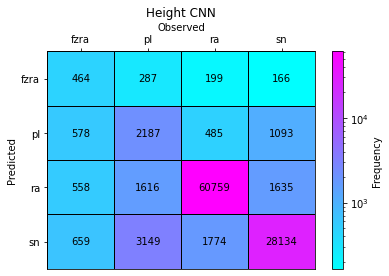

In [38]:
fig, ax = plt.subplots()
plt.pcolormesh(np.arange(0, 4), np.arange(0, 4), mc.table, norm=LogNorm(), edgecolors="k", cmap="cool")
plt.colorbar(label="Frequency")
for pc, pred_class in enumerate(np.unique(mping["train"]["precip"])):
    for oc, obs_class in enumerate(np.unique(mping["train"]["precip"])):
        plt.text(oc, pc, mc.table[pc, oc], ha="center", va="center") 
mc.table
plt.xticks(np.arange(0, 4))
plt.yticks(np.arange(0, 4))
ax.set_xticklabels(np.unique(mping["train"]["precip"]))
ax.set_yticklabels(np.unique(mping["train"]["precip"]))
ax.invert_yaxis()
ax.xaxis.tick_top()

plt.xlabel("Observed")
plt.ylabel("Predicted")
ax.xaxis.set_label_position('top')
plt.title("Height CNN")
plt.savefig("height_ct.png", dpi=200, bbox_inches="tight")

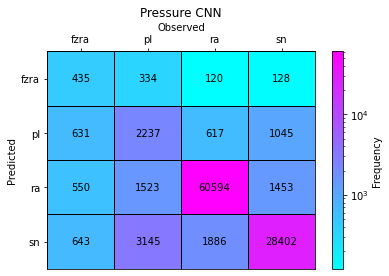

In [37]:
fig, ax = plt.subplots()
plt.pcolormesh(np.arange(0, 4), np.arange(0, 4), mc_p.table, norm=LogNorm(), edgecolors="k", cmap="cool")
plt.colorbar(label="Frequency")
for pc, pred_class in enumerate(np.unique(mping["train"]["precip"])):
    for oc, obs_class in enumerate(np.unique(mping["train"]["precip"])):
        plt.text(oc, pc, mc_p.table[pc, oc], ha="center", va="center") 
mc.table
plt.xticks(np.arange(0, 4))
plt.yticks(np.arange(0, 4))
ax.set_xticklabels(np.unique(mping["train"]["precip"]))
ax.set_yticklabels(np.unique(mping["train"]["precip"]))
ax.invert_yaxis()
ax.xaxis.tick_top()

plt.xlabel("Observed")
plt.ylabel("Predicted")
ax.xaxis.set_label_position('top')
plt.title("Pressure CNN")
plt.savefig("pressure_ct.png", dpi=200, bbox_inches="tight")

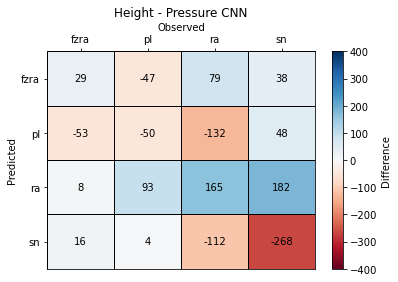

In [41]:
diff_table = mc.table - mc_p.table
fig, ax = plt.subplots()
plt.pcolormesh(np.arange(0, 4), np.arange(0, 4), diff_table, edgecolors="k", cmap="RdBu", vmin=-400, vmax=400)
plt.colorbar(label="Difference")
for pc, pred_class in enumerate(np.unique(mping["train"]["precip"])):
    for oc, obs_class in enumerate(np.unique(mping["train"]["precip"])):
        plt.text(oc, pc, diff_table[pc, oc], ha="center", va="center") 
mc.table
plt.xticks(np.arange(0, 4))
plt.yticks(np.arange(0, 4))
ax.set_xticklabels(np.unique(mping["train"]["precip"]))
ax.set_yticklabels(np.unique(mping["train"]["precip"]))
ax.invert_yaxis()
ax.xaxis.tick_top()

plt.xlabel("Observed")
plt.ylabel("Predicted")
ax.xaxis.set_label_position('top')
plt.title("Height - Pressure CNN")
plt.savefig("diff_ct.png", dpi=200, bbox_inches="tight")

array([[  435,   334,   120,   128],
       [  631,  2237,   617,  1045],
       [  550,  1523, 60594,  1453],
       [  643,  3145,  1886, 28402]])

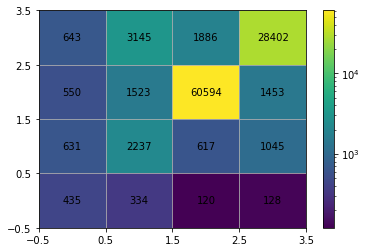

In [20]:
plt.pcolormesh(np.arange(0, 4), np.arange(0, 4), mc_p.table, norm=LogNorm())
plt.colorbar()
for pc, pred_class in enumerate(np.unique(mping["train"]["precip"])):
    for oc, obs_class in enumerate(np.unique(mping["train"]["precip"])):
        plt.text(oc, pc, mc_p.table[pc, oc], ha="center", va="center")
plt.xticks(np.arange(-.5, 4.5))
plt.yticks(np.arange(-.5, 4.5))

plt.grid(which="major")
mc_p.table

In [21]:
mc_p.gerrity_score()

0.462273559370796

In [22]:
mc.gerrity_score()

0.4595022104438028

In [23]:
mc.peirce_skill_score()

0.7544675400107963

In [24]:
mc_p.peirce_skill_score()

0.7594945721593187